In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
from tqdm import tqdm

In [ ]:
def gen_data(n, p):
    X, y = make_moons(n_samples=(int(n*p), n-int(n*p)), noise=0.1)
    return torch.from_numpy(X).float(), torch.from_numpy(y).long()

In [ ]:
def bayes_accuracy(xTrain, yTrain, xTest, yTest):
    model = nn.Sequential(
        nn.Linear(2, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(1000):
        optimizer.zero_grad()
        loss = F.binary_cross_entropy_with_logits(model(xTrain), yTrain.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
    return ((model(xTest) > 0) == yTest.unsqueeze(1)).float().mean().item()


In [ ]:
def train_on_source(xTrain, yTrain, xTest, yTest):
    '''
    Trains a logistic regression model on the source dataset and returns the model.
    '''
    model = nn.Sequential(nn.Linear(xTrain.shape[1], 1))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(100000):
        optimizer.zero_grad()
        loss = F.binary_cross_entropy_with_logits(model(xTrain), yTrain.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
    return model

In [ ]:
def adapt(model, xTarget, epochs = 100000):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model(xTarget)
        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        loss = F.binary_cross_entropy(probsPred, labelPreds)
        loss.backward()
        optimizer.step()
    return model

In [ ]:
def evaluate(model, xTest, yTest):
    '''
    Evaluates the model on the target dataset and returns the accuracy.
    '''
    return ((model(xTest) > 0) == yTest.unsqueeze(1)).float().mean().item()

In [ ]:
# plot the decision boundary of the linear neural network on the source dataset
def plot_decision_boundary(model, title, ax):
    x = np.linspace(-3, 3, 100)
    y = -model[0].bias.data.item()/model[0].weight.data[0,1].item() - model[0].weight.data[0,0].item()/model[0].weight.data[0,1].item() * x
    ax.plot(x, y, label=title)

In [ ]:
p = 0.75

xSourceTrain, ySourceTrain = gen_data(1000, 0.5)
xSourceTest, ySourceTest = gen_data(1000, 0.5)
xTargetTrain, yTargetTrain = gen_data(1000, p)
xTargetTest, yTargetTest = gen_data(1000, p)

In [ ]:
model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
sourceAccu = evaluate(model, xSourceTest, ySourceTest)
targetAccu = evaluate(model, xTargetTest, yTargetTest)
print("Source accuracy: ", sourceAccu)
print("Target accuracy: ", targetAccu)

Source accuracy:  0.8289999961853027
Target accuracy:  0.8230000138282776


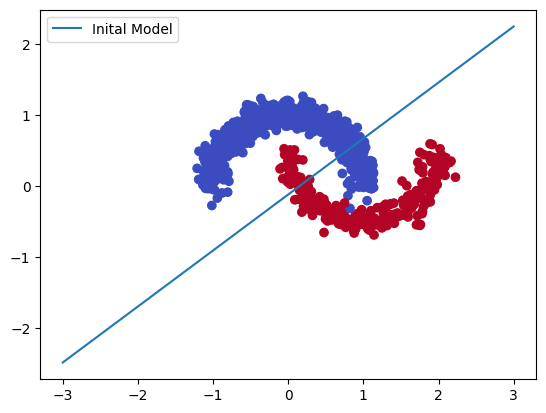

In [ ]:
plt.scatter(xTargetTrain[:,0], xTargetTrain[:,1], c=yTargetTrain, cmap='coolwarm')
plot_decision_boundary(model, 'Inital Model', plt.gca())
plt.legend()

In [ ]:
model = adapt(model, xTargetTrain)

100%|██████████| 100000/100000 [01:04<00:00, 1546.45it/s]


In [ ]:
sourceAccu = evaluate(model, xSourceTest, ySourceTest)
targetAccu = evaluate(model, xTargetTest, yTargetTest)
print("Source accuracy: ", sourceAccu)
print("Target accuracy: ", targetAccu)

Source accuracy:  0.8159999847412109
Target accuracy:  0.902999997138977


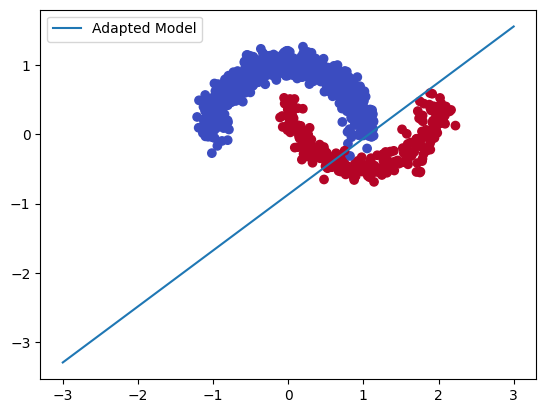

In [ ]:
plt.scatter(xTargetTrain[:,0], xTargetTrain[:,1], c=yTargetTrain, cmap='coolwarm')
plot_decision_boundary(model, 'Adapted Model', plt.gca())
plt.legend()

In [ ]:
# given a model and data. Predict the pseudo label and return the gradient of the model wrt the loss of the pseudo label of the points with pseudo label 1

def get_grad(model, x, y):
    '''
    Returns the gradient of the model wrt the loss of the pseudo label of the points with pseudo label 1
    '''
    # zero the model gradients
    model.zero_grad()

    predProbs = torch.sigmoid(model(x))
    predLabels = (predProbs > 0.5).float()
    loss = F.binary_cross_entropy(predProbs, predLabels)
    loss.backward()
    # print the gradient of the model wrt the loss of the pseudo label of the points with pseudo label 1
    return model[0].weight.grad.data

In [ ]:
probPred = torch.sigmoid(model(xTargetTrain))
pseudoLabels = (probPred > 0.5).float().squeeze()

In [ ]:
get_grad(model, xTargetTrain[pseudoLabels == 1], yTargetTrain[pseudoLabels == 1])

tensor([[-0.2263,  0.0289]])

In [ ]:
get_grad(model, xTargetTrain[pseudoLabels == 0], yTargetTrain[pseudoLabels == 0])

tensor([[0.0437, 0.0067]])

In [ ]:
get_grad(model, xTargetTrain, yTargetTrain)

tensor([[-0.0003,  0.0103]])

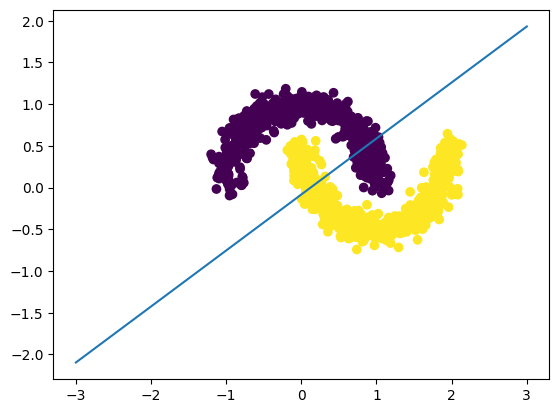

In [ ]:
plt.scatter(xTest[:, 0], xTest[:, 1], c=yTest)
plot_decision_boundary(model, 'temp', plt)

In [ ]:
model = adapt(model, xTest)

100%|██████████| 100000/100000 [00:42<00:00, 2358.73it/s]


In [ ]:
evaluate(model, xTest, yTest)

0.7990000247955322

Source accuracy: 0.8759999871253967
Source model on target accuracy: 0.878000020980835
Optimal linear model accuracy: 0.9190000295639038


100%|██████████| 100000/100000 [01:11<00:00, 1397.07it/s]


Bayes accuracy: 0.9980000257492065
Accuracy: 0.8460000157356262


Source accuracy: 0.8809999823570251
Source model on target accuracy: 0.8859999775886536
Optimal linear model accuracy: 0.9229999780654907


100%|██████████| 100000/100000 [01:09<00:00, 1440.18it/s]


Bayes accuracy: 1.0
Accuracy: 0.890999972820282


Source accuracy: 0.8809999823570251
Source model on target accuracy: 0.8830000162124634
Optimal linear model accuracy: 0.9179999828338623


100%|██████████| 100000/100000 [01:09<00:00, 1444.57it/s]


Bayes accuracy: 0.9980000257492065
Accuracy: 0.875


Source accuracy: 0.8830000162124634
Source model on target accuracy: 0.890999972820282
Optimal linear model accuracy: 0.9210000038146973


100%|██████████| 100000/100000 [01:10<00:00, 1420.49it/s]


Bayes accuracy: 0.9980000257492065
Accuracy: 0.8859999775886536


Source accuracy: 0.8799999952316284
Source model on target accuracy: 0.8790000081062317
Optimal linear model accuracy: 0.925000011920929


100%|██████████| 100000/100000 [01:21<00:00, 1220.02it/s]


Bayes accuracy: 0.9980000257492065
Accuracy: 0.871999979019165




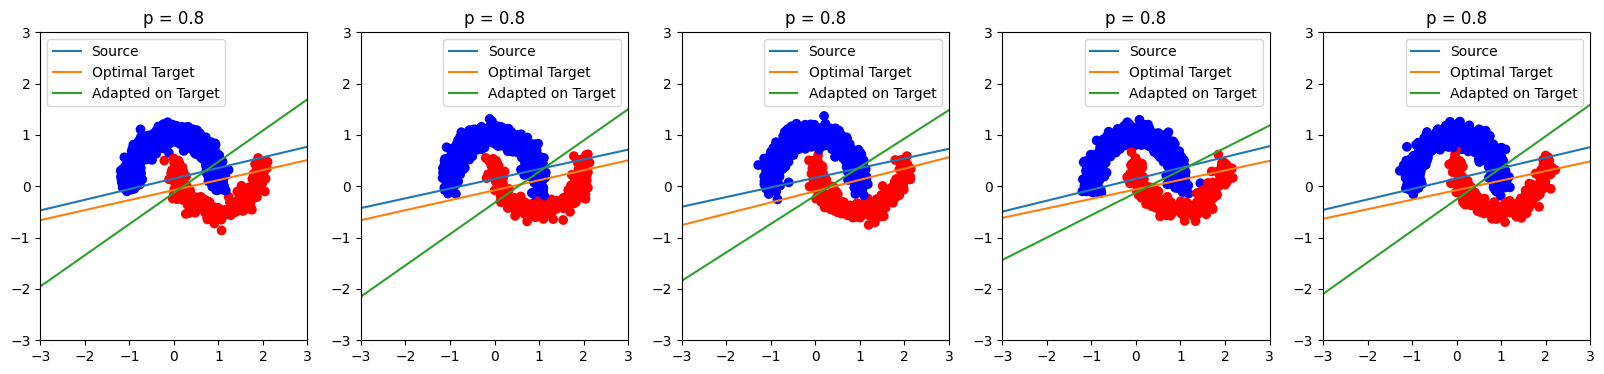

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    p = 0.8
    xSourceTrain, ySourceTrain = gen_data(1000, 0.5)
    xSourceTest, ySourceTest = gen_data(1000, 0.5)
    xTargetTrain, yTargetTrain = gen_data(1000, p)
    xTargetTest, yTargetTest = gen_data(1000, p)
    model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
    print('Source accuracy: {}'.format(evaluate(model, xSourceTest, ySourceTest)))
    print('Source model on target accuracy: {}'.format(evaluate(model, xTargetTest, yTargetTest)))
    targetModel = train_on_source(xTargetTest, yTargetTest, xTargetTest, yTargetTest)
    print('Optimal linear model accuracy: {}'.format(evaluate(targetModel, xTargetTest, yTargetTest)))
    plot_decision_boundary(model, 'Source', ax[i])
    plot_decision_boundary(targetModel, 'Optimal Target', ax[i])
    model = adapt(model, xTargetTrain)
    plot_decision_boundary(model, 'Adapted on Target', ax[i])
    ax[i].scatter(xTargetTrain[:,0], xTargetTrain[:,1], c=yTargetTrain, cmap='bwr')
    ax[i].set_title('p = {}'.format(p))
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].legend()
    print('Bayes accuracy: {}'.format(bayes_accuracy(xTargetTrain, yTargetTrain, xTargetTest, yTargetTest)))
    print('Accuracy: {}'.format(evaluate(model, xTargetTest, yTargetTest)))
    print("\n")
plt.show()


100%|██████████| 1000000/1000000 [11:34<00:00, 1440.08it/s]


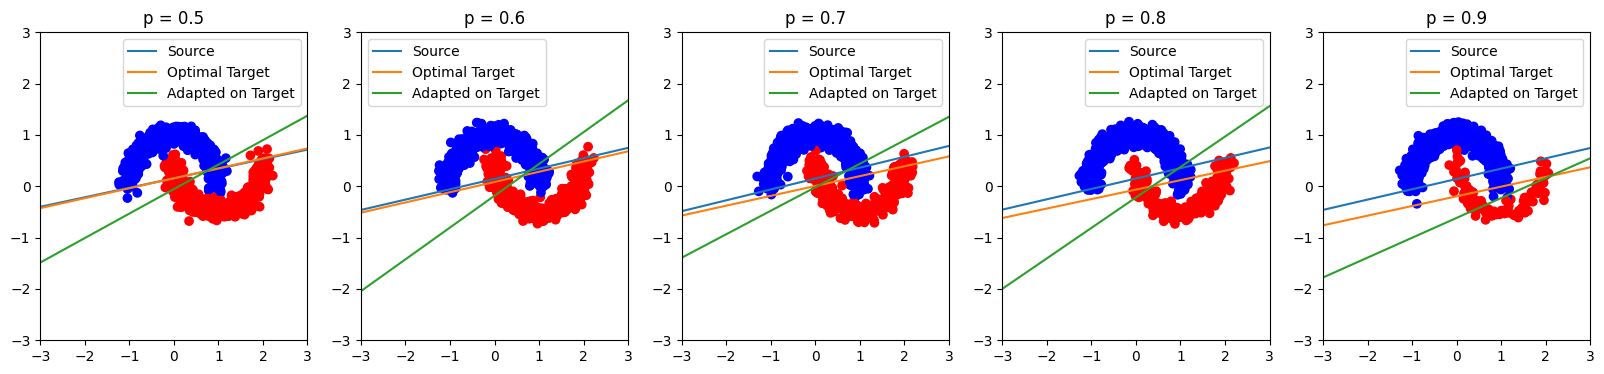

In [ ]:
adaptedAccus = []
optimalAccus = []
sourceModelAccus = []
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, p in enumerate([0.5, 0.6, 0.7, 0.8, 0.9]):
    xSourceTrain, ySourceTrain = gen_data(1000, 0.5)
    xSourceTest, ySourceTest = gen_data(1000, 0.5)
    xTargetTrain, yTargetTrain = gen_data(1000, p)
    xTargetTest, yTargetTest = gen_data(1000, p)
    model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
    sourceModelAccus.append(evaluate(model, xTargetTest, yTargetTest))
    targetModel = train_on_source(xTargetTest, yTargetTest, xTargetTest, yTargetTest)
    plot_decision_boundary(model, 'Source', ax[i])
    plot_decision_boundary(targetModel, 'Optimal Target', ax[i])
    model = adapt(model, xTargetTrain, epochs = 1_000_000)
    adaptedAccus.append(evaluate(model, xTargetTest, yTargetTest))
    optimalAccus.append(evaluate(targetModel, xTargetTest, yTargetTest))
    plot_decision_boundary(model, 'Adapted on Target', ax[i])
    ax[i].scatter(xTargetTrain[:,0], xTargetTrain[:,1], c=yTargetTrain, cmap='bwr')
    ax[i].set_title('p = {}'.format(p))
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].legend()
plt.show()

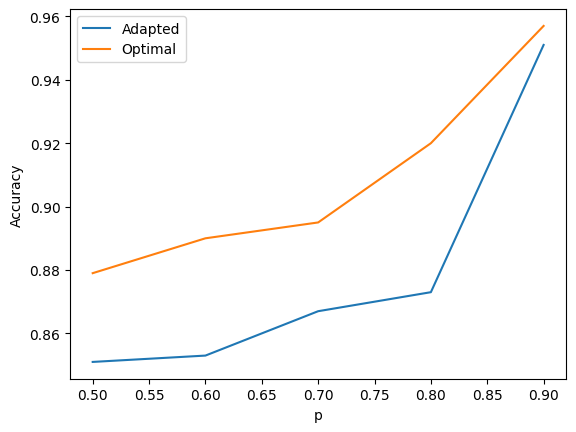

In [ ]:
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9], adaptedAccus, label='Adapted')
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9], optimalAccus, label='Optimal')
plt.xlabel('p')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
adaptedAccus, optimalAccus, sourceModelAccus

([0.8510000109672546,
  0.8529999852180481,
  0.8669999837875366,
  0.8730000257492065,
  0.9509999752044678],
 [0.8790000081062317,
  0.8899999856948853,
  0.8949999809265137,
  0.9200000166893005,
  0.9570000171661377],
 [0.8790000081062317,
  0.8859999775886536,
  0.8799999952316284,
  0.8840000033378601,
  0.875])